In [1]:
import pandas as pd
import numpy as np


connections = pd.read_csv("Data/Walking Distances Gate-to-Gate.csv")

pair_dists = connections.to_numpy().astype(np.float64)

# Handle NaNs or missing values if any
pair_dists = np.nan_to_num(pair_dists, nan=np.inf)  # or set to large value

# Min-max normalization (excluding infinities)
finite_vals = pair_dists[np.isfinite(pair_dists)]
min_val = np.min(finite_vals)
max_val = np.max(finite_vals)

normalized_dists = (pair_dists - min_val) / (max_val - min_val)
normalized_dists[~np.isfinite(pair_dists)] = 1.0  # keep inf as 1 (furthest apart)

# pair_dists = normalized_dists

median_distance = np.median(pair_dists[np.isfinite(pair_dists)])  # Exclude infinities (or NaNs)
print(f"Median distance: {median_distance}")

Median distance: 1095.5


# Code to construct clustered medoids

In [3]:
from sklearn.metrics import pairwise_distances_argmin_min

def k_medoids_single_run(pair_dists, k, max_iter=300):
    n = pair_dists.shape[0]
    curr_medoids = np.random.choice(n, k, replace=False)

    for _ in range(max_iter):
        labels = np.argmin(pair_dists[:, curr_medoids], axis=1)
        new_medoids = np.copy(curr_medoids)

        for cluster_id in range(k):
            cluster_points = np.where(labels == cluster_id)[0]
            if len(cluster_points) == 0:
                continue
            intra_cluster_dists = pair_dists[np.ix_(cluster_points, cluster_points)]
            total_dists = np.sum(intra_cluster_dists, axis=1)
            new_medoids[cluster_id] = cluster_points[np.argmin(total_dists)]

        if np.all(curr_medoids == new_medoids):
            break
        curr_medoids = new_medoids

    final_labels = np.argmin(pair_dists[:, curr_medoids], axis=1)
    return final_labels, curr_medoids

def compute_medoids_mse(pair_dists, labels, medoids):
    medoid_map = np.array(medoids)[labels]
    approx_dists = pair_dists[np.ix_(medoid_map, medoid_map)]
    mse = np.mean((pair_dists - approx_dists) ** 2)
    return mse

def k_medoids(pair_dists, k, max_iter=300, n_init=1000, verbose=False):
    best_loss = float("inf")
    best_labels, best_medoids = None, None

    for i in range(n_init):
        labels, medoids = k_medoids_single_run(pair_dists, k, max_iter)
        mse_loss = compute_medoids_mse(pair_dists, labels, medoids)

        if verbose:
            print(f"[Run {i+1}] MSE Loss: {mse_loss:.6f}")

        if mse_loss < best_loss:
            best_loss = mse_loss
            best_labels = labels
            best_medoids = medoids

    return best_labels, best_medoids



labels, medoids = k_medoids(pair_dists, k=6)
print("Cluster assignments:", labels)
print("Medoid indices:", medoids)

mse_loss = compute_medoids_mse(pair_dists, labels, medoids)
print("MSE loss of medoid approximation:", mse_loss)

Cluster assignments: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5
 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Medoid indices: [19 35 57  6 87 73]
MSE loss of medoid approximation: 35525.767578125


In [4]:
def get_medoid_distance_matrix(pair_dists, medoids):
    """
    Returns the pairwise distance matrix between medoids.

    Args:
        pair_dists (np.ndarray): Full NxN pairwise distance matrix.
        medoids (list or np.ndarray): List of indices of medoid points.

    Returns:
        np.ndarray: KxK distance matrix between medoids.
    """
    medoids = np.array(medoids)
    return pair_dists[np.ix_(medoids, medoids)]

pair_dists_medoid = get_medoid_distance_matrix(pair_dists, medoids)

print("Pairwise distance matrix between medoids:")
print(pair_dists_medoid)

Pairwise distance matrix between medoids:
[[   0.  923. 1433.  459.  957.  653.]
 [ 923.    0.  591. 1369. 1680. 1376.]
 [1433.  591.    0. 1055. 2117. 1813.]
 [ 459. 1369. 1055.    0. 1329. 1024.]
 [ 957. 1680. 2117. 1329.    0.  436.]
 [ 653. 1376. 1813. 1024.  436.    0.]]


# Function to linearize given set of pairwise distances

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
def optimize_1T_E_minus_1T_S(pair_dists, d=2, num_iters=10000, lr=1e-2, verbose=True):
    """
    Optimize E and S to minimize sum((1^T E_i - 1^T S_j - pair_dists[i,j])^2)
    
    pair_dists: torch.Tensor of shape (k, k)
    d: dimensionality of E and S
    """
    k = pair_dists.shape[0]
    
    # E and S are k x d matrices
    E = torch.randn((k, d), requires_grad=True)
    S = torch.randn((k, d), requires_grad=True)
    
    optimizer = optim.Adam([E, S], lr=lr)
    
    for iter in range(num_iters):
        optimizer.zero_grad()
        
        # 1^T E_i = sum over dim-1 (axis=1) → shape (k,)
        E_sum = E.sum(dim=1)  # shape (k,)
        S_sum = S.sum(dim=1)  # shape (k,)

        # Compute outer difference: E_sum[i] - S_sum[j]
        # Assume E_sum and S_sum are 1D tensors of shape (k,)
        E_sum = E_sum.view(-1, 1)  # Shape: (k, 1)
        S_sum = S_sum.view(1, -1)  # Shape: (1, k)

        diff_matrix = E_sum - S_sum  # Shape: (k, k)
        #torch.diagonal(diff_matrix).zero_()  # Set diagonal to 0 in-place


        # Compute loss
        loss = ((diff_matrix - pair_dists) ** 2).mean()
        loss.backward()
        optimizer.step()
        
        if verbose and iter % 100 == 0:
            print(f"Iter {iter}: Loss = {loss.item():.6f}")
    
    return E.detach(), S.detach(), loss.item()

def linearize_analytical(pair_dists):
    """
    Linearize the pairwise distance matrix using the analytical solution.
    
    Args:
        pair_dists (np.ndarray): Pairwise distance matrix of shape (k, k).
        
    
    """
    num_vars = pair_dists.shape[0] * 2

    A = []
    b = []

    for i in range(pair_dists.shape[0]):
        for j in range(pair_dists.shape[0]):
            exn = np.zeros(num_vars)
            exn[i] = 1
            exn[j + pair_dists.shape[0]] = -1

            A.append(exn)

            b.append(pair_dists[i, j])

    A = np.array(A)
    b = np.array(b)

    opt_sol, res, rank, s = np.linalg.lstsq(A, b)

    E = opt_sol[:pair_dists.shape[0]]
    S = opt_sol[pair_dists.shape[0]:]

    return E, S, res

In [ ]:
torch.manual_seed(0)
d = 300


pair_dists_torch = torch.tensor(pair_dists, dtype=torch.float32)
    
# Optimize to recover E and S
E_opt, S_opt, loss = optimize_1T_E_minus_1T_S(pair_dists_torch, d=d)
print("Recovered E sums:", E_opt.sum(dim=1))
print("Recovered S sums:", S_opt.sum(dim=1))

In [6]:
# Save the optimized E and S matrices

np.savetxt("Data/E_optimized.csv", E_opt.sum(dim=1).numpy(), delimiter=",")
np.savetxt("Data/S_optimized.csv", S_opt.sum(dim=1).numpy(), delimiter=",")


In [10]:
torch.manual_seed(0)
d = 300


pair_dists_medoid_torch = torch.tensor(pair_dists_medoid, dtype=torch.float32)
    
# Optimize to recover E and S
E_opt, S_opt, loss = optimize_1T_E_minus_1T_S(pair_dists_medoid_torch, d=d)
print("Recovered E sums:", E_opt.sum(dim=1))
print("Recovered S sums:", S_opt.sum(dim=1))

Iter 0: Loss = 1271846.750000
Iter 100: Loss = 553886.062500
Iter 200: Loss = 378526.593750
Iter 300: Loss = 346516.500000
Iter 400: Loss = 339717.093750
Iter 500: Loss = 338201.312500
Iter 600: Loss = 337905.312500
Iter 700: Loss = 337856.875000
Iter 800: Loss = 337850.312500
Iter 900: Loss = 337849.625000
Iter 1000: Loss = 337849.500000
Iter 1100: Loss = 337849.500000
Iter 1200: Loss = 337849.500000
Iter 1300: Loss = 337849.500000
Iter 1400: Loss = 337849.500000
Iter 1500: Loss = 337849.500000
Iter 1600: Loss = 337849.500000
Iter 1700: Loss = 337849.500000
Iter 1800: Loss = 337849.531250
Iter 1900: Loss = 337849.500000
Iter 2000: Loss = 337849.500000
Iter 2100: Loss = 337849.500000
Iter 2200: Loss = 337849.500000
Iter 2300: Loss = 337849.500000
Iter 2400: Loss = 337849.500000
Iter 2500: Loss = 337849.500000
Iter 2600: Loss = 337849.500000
Iter 2700: Loss = 337849.500000
Iter 2800: Loss = 337849.500000
Iter 2900: Loss = 337849.500000
Iter 3000: Loss = 337849.500000
Iter 3100: Loss = 3

In [11]:
# 1^T E_i = sum over dim-1 (axis=1) → shape (k,)
E_sum = E_opt.sum(dim=1)  # shape (k,)
S_sum = S_opt.sum(dim=1)  # shape (k,)

# Compute outer difference: E_sum[i] - S_sum[j]
# Assume E_sum and S_sum are 1D tensors of shape (k,)
E_sum = E_sum.view(-1, 1)  # Shape: (k, 1)
S_sum = S_sum.view(1, -1)  # Shape: (1, k)

diff_matrix = E_sum - S_sum  # Shape: (k, k)

print("Pairwise distance matrix between medoids after optimization:")
print(diff_matrix)

Pairwise distance matrix between medoids after optimization:
tensor([[ 518.6111,  770.9445,  949.2778,  653.7778,  867.6112,  664.7778],
        [ 770.9445, 1023.2778, 1201.6111,  906.1111, 1119.9446,  917.1111],
        [ 949.2778, 1201.6111, 1379.9445, 1084.4445, 1298.2778, 1095.4445],
        [ 653.7778,  906.1111, 1084.4445,  788.9445, 1002.7778,  799.9445],
        [ 867.6111, 1119.9445, 1298.2778, 1002.7778, 1216.6111, 1013.7778],
        [ 664.7777,  917.1111, 1095.4443,  799.9444, 1013.7778,  810.9444]])


In [8]:
print("E and S matrices after optimization:")
print("E:", E_sum)
print("S:", S_sum)

E and S matrices after optimization:
E: tensor([[249.4860],
        [627.9860],
        [895.4860],
        [452.2360],
        [772.9860],
        [468.7360]])
S: tensor([[-241.5140, -620.0140, -887.5140, -444.2640, -765.0140, -460.7639]])


In [48]:
e_list = E_opt.sum(dim=1).numpy()
s_list = S_opt.sum(dim=1).numpy()

e_list = e_list[labels]
s_list = s_list[labels]
# Save the optimized E and S matrices

np.savetxt("Data/E_optimized_clust.csv", e_list, delimiter=",")
np.savetxt("Data/S_optimized_clust.csv", s_list, delimiter=",")


# Find optimal clustering level

Running k-medoids with k = 4
MSE loss of medoid approximation: 75330.05013020833
MSE of linear approximation for k=4: 83029.546875
Total loss for k=4: 158359.597005
Running k-medoids with k = 5
MSE loss of medoid approximation: 52818.909071180555
MSE of linear approximation for k=5: 168230.843750
Total loss for k=5: 221049.752821
Running k-medoids with k = 6
MSE loss of medoid approximation: 35525.767578125
MSE of linear approximation for k=6: 134395.640625
Total loss for k=6: 169921.408203
Running k-medoids with k = 7
MSE loss of medoid approximation: 24855.009114583332
MSE of linear approximation for k=7: 186620.515625
Total loss for k=7: 211475.524740
Running k-medoids with k = 8
MSE loss of medoid approximation: 20369.069661458332
MSE of linear approximation for k=8: 201081.765625
Total loss for k=8: 221450.835286
Running k-medoids with k = 9
MSE loss of medoid approximation: 16170.050564236111
MSE of linear approximation for k=9: 268568.093750
Total loss for k=9: 284738.144314


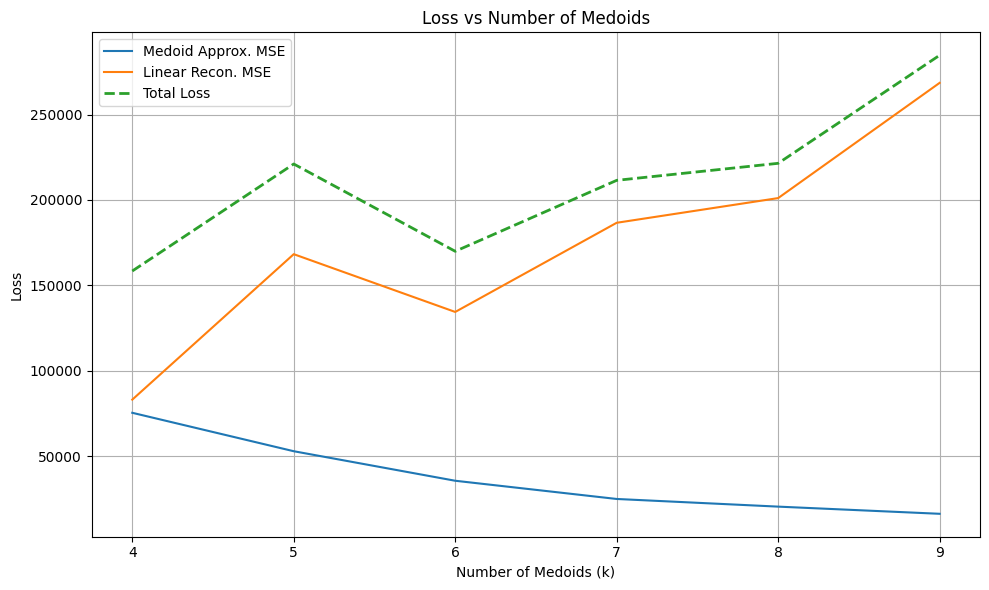


Minimum total loss 158359.597005 at k=4


In [51]:
import matplotlib.pyplot as plt
import torch
import numpy as np

medoid_vals = list(range(4, 10, 1))
medoid_approx_losses = []
linear_reconstruction_losses = []
total_losses = []

min_num_medoid = -1
min_medoid_loss = float("inf")

for k in medoid_vals:
    print("Running k-medoids with k =", k)

    labels, medoids = k_medoids(pair_dists, k=k)
    mse_loss = compute_medoids_mse(pair_dists, labels, medoids)
    print("MSE loss of medoid approximation:", mse_loss)

    pair_dists_medoid = get_medoid_distance_matrix(pair_dists, medoids)

    torch.manual_seed(0)
    d = 300
    pair_dists_medoid_torch = torch.tensor(pair_dists_medoid, dtype=torch.float32)

    # Optimize to recover E and S
    E_opt, S_opt, loss = optimize_1T_E_minus_1T_S(pair_dists_medoid_torch, d=d, verbose=False)
    print(f"MSE of linear approximation for k={k}: {loss:.6f}")

    e_list = E_opt.sum(dim=1).numpy()
    s_list = S_opt.sum(dim=1).numpy()

    e_list = e_list[labels]
    s_list = s_list[labels]

    # Save the optimized E and S matrices

    np.savetxt(f"Data/E_optimized_clust{k}.csv", e_list, delimiter=",")
    np.savetxt(f"Data/S_optimized_clust{k}.csv", s_list, delimiter=",")


    total_loss = mse_loss + loss
    print(f"Total loss for k={k}: {total_loss:.6f}")

    # Save all losses
    medoid_approx_losses.append(mse_loss)
    linear_reconstruction_losses.append(loss)
    total_losses.append(total_loss)

    if total_loss < min_medoid_loss:
        min_medoid_loss = total_loss
        min_num_medoid = k

# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(medoid_vals, medoid_approx_losses, label='Medoid Approx. MSE')
plt.plot(medoid_vals, linear_reconstruction_losses, label='Linear Recon. MSE')
plt.plot(medoid_vals, total_losses, label='Total Loss', linestyle='--', linewidth=2)

plt.xlabel('Number of Medoids (k)')
plt.ylabel('Loss')
plt.title('Loss vs Number of Medoids')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nMinimum total loss {min_medoid_loss:.6f} at k={min_num_medoid}")
